# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [ ]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

#### Import packages

In [ ]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [ ]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 128,
    n_epoch = 10,
    lr = 1e-4,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [ ]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

#### Dataset and Dataloader

In [ ]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [ ]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    # T.Normalize(mean=[0.485], std=[0.229]),
])
eval_tfm = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=[0.485], std=[0.229])
])

In [ ]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

#### Model

In [ ]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x

#### training loop

In [ ]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

100%|██████████| 181/181 [00:24<00:00,  7.41it/s]


Epoch: 1/10, train loss: 1.7146, train acc: 0.3142
Epoch: 1/10, valid loss: 1.6427, valid acc: 0.3688
== best valid acc: 0.3688 ==


100%|██████████| 181/181 [00:23<00:00,  7.58it/s]


Epoch: 2/10, train loss: 1.6095, train acc: 0.3781
Epoch: 2/10, valid loss: 1.5955, valid acc: 0.3671


100%|██████████| 181/181 [00:24<00:00,  7.49it/s]


Epoch: 3/10, train loss: 1.5707, train acc: 0.3961
Epoch: 3/10, valid loss: 1.5622, valid acc: 0.4055
== best valid acc: 0.4055 ==


100%|██████████| 181/181 [00:24<00:00,  7.49it/s]


Epoch: 4/10, train loss: 1.5415, train acc: 0.4108
Epoch: 4/10, valid loss: 1.5541, valid acc: 0.4063
== best valid acc: 0.4063 ==


100%|██████████| 181/181 [00:24<00:00,  7.52it/s]


Epoch: 5/10, train loss: 1.5206, train acc: 0.4202
Epoch: 5/10, valid loss: 1.5190, valid acc: 0.4176
== best valid acc: 0.4176 ==


100%|██████████| 181/181 [00:23<00:00,  7.54it/s]


Epoch: 6/10, train loss: 1.4977, train acc: 0.4309
Epoch: 6/10, valid loss: 1.5014, valid acc: 0.4261
== best valid acc: 0.4261 ==


100%|██████████| 181/181 [00:23<00:00,  7.55it/s]


Epoch: 7/10, train loss: 1.4765, train acc: 0.4372
Epoch: 7/10, valid loss: 1.4886, valid acc: 0.4321
== best valid acc: 0.4321 ==


100%|██████████| 181/181 [00:24<00:00,  7.53it/s]


Epoch: 8/10, train loss: 1.4518, train acc: 0.4472
Epoch: 8/10, valid loss: 1.4703, valid acc: 0.4351
== best valid acc: 0.4351 ==


100%|██████████| 181/181 [00:24<00:00,  7.48it/s]


Epoch: 9/10, train loss: 1.4363, train acc: 0.4534
Epoch: 9/10, valid loss: 1.4421, valid acc: 0.4419
== best valid acc: 0.4419 ==


100%|██████████| 181/181 [00:24<00:00,  7.52it/s]


Epoch: 10/10, train loss: 1.4148, train acc: 0.4648
Epoch: 10/10, valid loss: 1.4291, valid acc: 0.4533
== best valid acc: 0.4533 ==


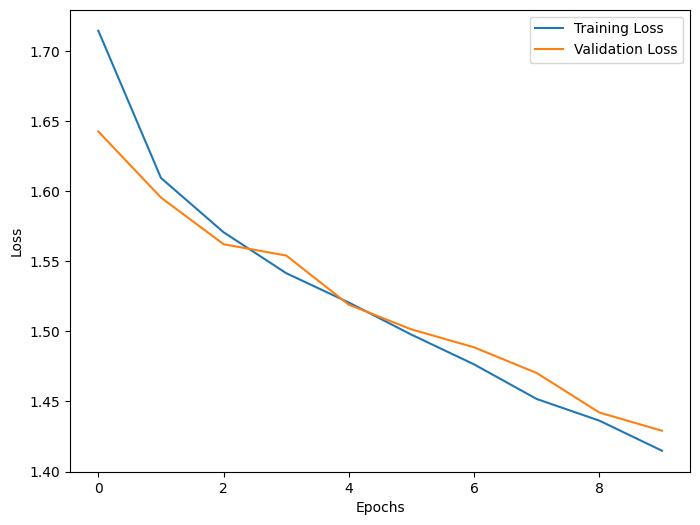

In [ ]:
model = FaceExpressionNet()
train(model, train_loader, valid_loader, config)

In [ ]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix

draw_confusion_matrix(model, valid_loader)


100%|██████████| 46/46 [00:04<00:00, 11.07it/s]


### Testing

In [ ]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [ ]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)

100%|██████████| 55/55 [00:04<00:00, 12.50it/s]
